In [11]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
from diffusionProcess import DiffusionProcess, drift, sigma, generate_linear_drift
from strategies import DataDrivenImpulseControl, generate_reward_func
from sklearn.neighbors import KernelDensity
plt.style.use(r"C:\Users\razz_\AppData\Local\Programs\Python\Python310\Lib\site-packages\matplotlib\mpl-data\stylelib\theme_bw.mplstyle")

## Plotting the kernel functions

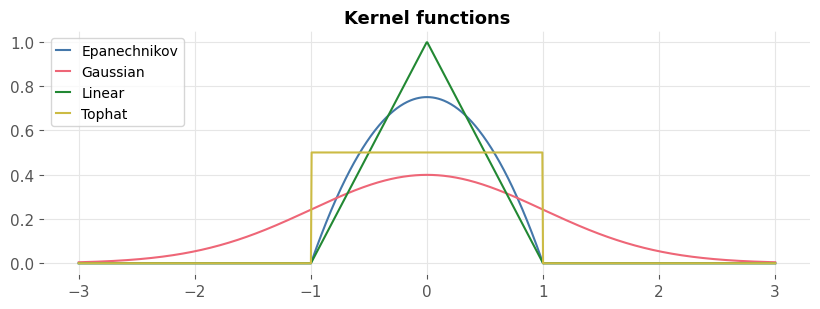

In [26]:
colors = ['#4477AA', '#EE6677', '#228833', "#CCBB44"]
Kernels = ["epanechnikov", "gaussian", "linear", "tophat"]
bandwidths = [0.5, 1]

fig, ax = plt.subplots(1,1,figsize=(8.3, 3.2))

X_src = np.zeros((1, 1))
x_grid = np.linspace(-3, 3, 1000)

for i, kernel in enumerate(Kernels):
    log_dens = KernelDensity(kernel=kernel, bandwidth=1).fit(X_src).score_samples(x_grid[:, None])
    ax.plot(x_grid, np.exp(log_dens), color=colors[i], label=kernel.capitalize())
ax.legend(loc="upper left", handlelength=1, handleheight=0.5)
ax.set_title("Kernel functions", fontsize=13, fontweight="bold")
#ax[0].set_xlabel("X", fontsize=12)
ax.ticklabel_format(style="plain")
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)

plt.tight_layout()
#plt.savefig(r'C:\Users\razz_\OneDrive - Aarhus Universitet\UNI\DataVidenskab\10. Semester\Images\KernelChanges\KernelFunctions.pdf')
plt.show()

## Kernel bandwidths

The idea of this notebook is to see how the bandwidth affects the estimation of the invariant density for different kernels. Therefore, we will fix a drift function to be of the form:
$$
b(x) = -0.5x
$$
and see how changing the bandwidth affects the plot and MISE of the invariant density for different kernels.

### Changing the constant
The optimal bandwidth is of the form: $\frac{1}{\sqrt{T}}$, but how does it affect estimation of the invariant density if we change the constant in the numerator?

We will look at four different constants: 0.5, 1, 2, 4 for the gaussian, tophat, linear and epanechnikov kernels.

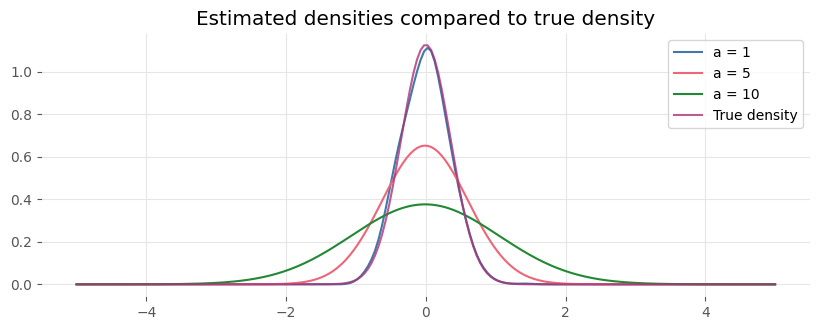

In [37]:
def get_bandwidth(a, T):
    if isinstance(a, str):
        return a
    return a/np.sqrt(T)

b = generate_linear_drift(4, 0)
r = generate_reward_func(1, 0.9)

diffProcess = DiffusionProcess(b, sigma)
dataStrat = DataDrivenImpulseControl(r, sigma)

kernel_methods = ["gaussian"]
constants = [1, 5, 10]
vals = np.linspace(-5, 5, 200)
ST = 100
T = ST**(3/2)

data, t = diffProcess.EulerMaruymaMethod(ST, 0.01, 0)
dens = [diffProcess.invariant_density(v) for v in vals]

fData = []

for const in constants:
    const_data = []
    for kernel in kernel_methods:
        dataStrat.kernel_method = kernel
        dataStrat.bandwidth = get_bandwidth(const, ST)
        dataStrat.fit(data)
        fs = [dataStrat.pdf_eval(v) for v in vals]
        const_data.append(fs)
    fData.append(const_data)

colors = ['#4477AA', '#EE6677', '#228833']

fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8.3, 3.4))
for i, c in enumerate(constants):
    axes.plot(vals, fData[i][0], label=f"a = {c}", color=colors[i])
    # axes[i//2][i%2].plot(vals, fData[i][1], label="linear")
    # axes[i//2][i%2].plot(vals, fData[i][2], label="tophat")
    # axes[i//2][i%2].plot(vals, fData[i][3], label="epanechnikov")
axes.plot(vals, dens, label="True density", color="#AA3377", alpha=0.8)
axes.legend()
axes.set_title("Estimated densities compared to true density")
plt.tight_layout()
plt.show()

Here we see that the different kernels do fit differently depending on the bandwidth. If the bandwidth is the standard $\frac{1}{\sqrt{T}}$, then the four kernels have basically the same fit, but when we change the constant, then the kernels do fit differently. A higher constant makes the fit more smooth, and opposite a smaller constant makes the fit more sensitive. After playing around with these values it also became evident, that the change in the constant of the bandwidth does not really change the estimates of the invariant density for the different kernels methods, when the number of data points are high, meaning for higher exploration times. It is only really a problem, if the exploration time is low, meaning that there is a few data points to use to estimate fit the kernel density estimator on.

Another interesting thing would be to try and change the factor of T. To test this we will use the four different kernels:
$$
T^{-1/2}, \quad T^{-1/3}, \quad T^{-1/4}, \quad T^{-1/5} 
$$

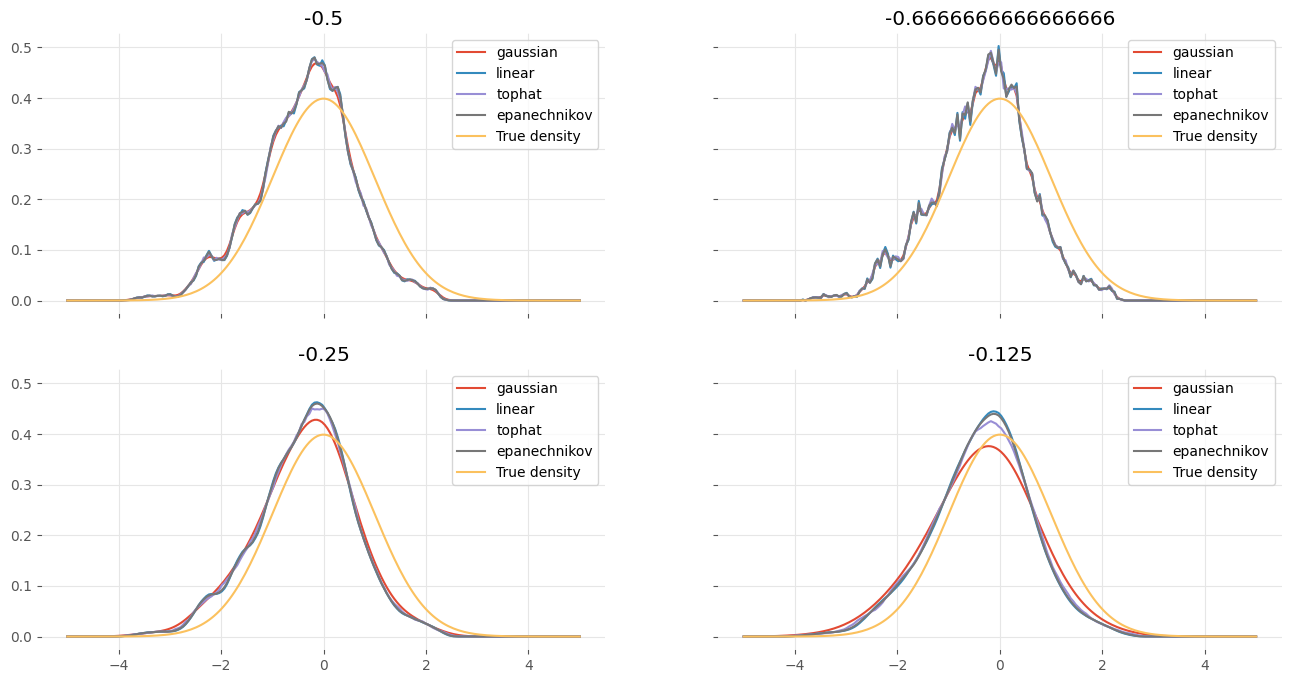

In [8]:
def get_bandwidth2(p, T):
    return T**p

b = generate_linear_drift(4, 0)
r = generate_reward_func(1, 0.9)

diffProcess = DiffusionProcess(b, sigma)
dataStrat = DataDrivenImpulseControl(r, sigma)

kernel_methods = ["gaussian", "linear", "tophat", "epanechnikov"]
ps = [-1/1.5, -1/2, -1/4, -1/8]
vals = np.linspace(-2, 2, 200)
ST = 100


data, t = diffProcess.EulerMaruymaMethod(ST, 0.01, 0)
dens = [diffProcess.invariant_density(v) for v in vals]

fData = []

for p in ps:
    const_data = []
    for kernel in kernel_methods:
        dataStrat.kernel_method = kernel
        dataStrat.bandwidth = get_bandwidth2(p, ST)
        dataStrat.fit(data)
        fs = [dataStrat.pdf_eval(v) for v in vals]
        const_data.append(fs)
    fData.append(const_data)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16,8))
for i, p in enumerate(ps):
    axes[i//2][i%2].plot(vals, fData[i][0], label="gaussian")
    axes[i//2][i%2].plot(vals, fData[i][1], label="linear")
    axes[i//2][i%2].plot(vals, fData[i][2], label="tophat")
    axes[i//2][i%2].plot(vals, fData[i][3], label="epanechnikov")
    axes[i//2][i%2].plot(vals, dens, label="True density")
    axes[i//2][i%2].legend()
    axes[i//2][i%2].set_title(str(p))
plt.show()

Here we also see that though the different factors of the bandwidth does affect the kernels ability to estimate the invariant density, then there are really no difference between the four kernels.

Therefore I must conclude that changing the bandwidth has has an effect, but that in terms of the kernel used, then it affects all kernels the same except for when the number of samples are very small.